# Analytics - Product Quality

#### Date: 2020/02

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: YYYY/0X
##### Professor: Hilmer Neri

##### Members:

- Member x
- Member y

### LIBRARIES

In [2]:
# Deal with data
import pandas as pd
import json
from glob import glob
import os
import re

# Deal with visualization
import matplotlib.pyplot as plt

# Deal with time
import datetime

### GRAPH SETTINGS

In [3]:
fig = plt.figure(figsize=(20, 10))

<Figure size 1440x720 with 0 Axes>

### DATAFRAME SETTINGS

In [4]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

#### Replace your semester, project name, repository name, and the programming language extension

In [16]:
language = [['fga-eps-mds-2022-1-Capju-User', 'js'],
           ['fga-eps-mds-2022-1-Capju-Interface', 'js'],
           ['fga-eps-mds-2022-1-Capju-Service', 'js']]

repos_language = {}

for item in language:
    repos_language[f"{item[0]}"] = item[1]

### SonarCloud

##### Path to the folder with all your jsons

In [6]:
jsons = glob('analytics-raw-data/2022-1-CAPJu/*.json') # add your path here

In [7]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    # Replace the UnB semester with yours.
    aux_df = df['filename'].str.split(r"fga-eps-mds-2022.1-(.*?)-(.*?)-(.*?)-(.*?)-v(.*?).json", expand=True)

    df['repository'] = aux_df[2]

    df['version'] = aux_df[5]

    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [8]:
base_component_df = create_base_component_df(jsons)

/tmp/ipykernel_489224/1251919851.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_489224/1251919851.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_489224/1251919851.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_489224/1251919851.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_489224/1251919851.py:22: FutureWarning: The frame.append method is deprec

In [9]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
40,duplicated_lines_density,0.0,True,fga-eps-mds-2022-1-Capju-Interface-07-31-2022-...,Interface,0.1.0
41,functions,82,NaN,fga-eps-mds-2022-1-Capju-Interface-07-31-2022-...,Interface,0.1.0
42,security_rating,1.0,True,fga-eps-mds-2022-1-Capju-Interface-07-31-2022-...,Interface,0.1.0
43,files,28,NaN,fga-eps-mds-2022-1-Capju-Interface-07-31-2022-...,Interface,0.1.0
44,complexity,97,NaN,fga-eps-mds-2022-1-Capju-Interface-07-31-2022-...,Interface,0.1.0
45,ncloc,1361,NaN,fga-eps-mds-2022-1-Capju-Interface-07-31-2022-...,Interface,0.1.0
46,coverage,0.0,False,fga-eps-mds-2022-1-Capju-Interface-07-31-2022-...,Interface,0.1.0
47,comment_lines_density,0.1,False,fga-eps-mds-2022-1-Capju-Interface-07-31-2022-...,Interface,0.1.0
104,duplicated_lines_density,0.0,True,fga-eps-mds-2022-1-Capju-Interface-08-17-2022-...,Interface,0.2.0
105,functions,109,NaN,fga-eps-mds-2022-1-Capju-Interface-08-17-2022-...,Interface,0.2.0


#### Create dataframe per file

In [10]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

len(metric_list)

12

In [17]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_name = os.path.basename(i)

        file_repository = re.split(r'-(\d+-\d+-\d+-\d+-\d+-\d+)-v(.*?).json', file_name)[0]

        file_language = repos_language[f"{file_repository}"]

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = file_language)

        file_component_df['filename'] = os.path.basename(i)

        df = df.append(file_component_df, ignore_index=True)
        
    # Replace the UnB semester with yours.
    aux_df = df['filename'].str.split(r"-(\d+-\d+-\d+-\d+-\d+-\d+)-v(.*?).json", expand=True)

    df['repository'] = aux_df[0]

    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'version'])

    return df

In [18]:
file_component_df = create_file_df(jsons)
file_component_df.repository.unique()

/tmp/ipykernel_489224/688069433.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_489224/688069433.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_489224/688069433.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_489224/688069433.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_489224/688069433.py:49: FutureWarning: The frame.append method is deprecated 

array(['fga-eps-mds-2022-1-Capju-Interface',
       'fga-eps-mds-2022-1-Capju-Service',
       'fga-eps-mds-2022-1-Capju-User'], dtype=object)

#### Removing NaN

In [19]:
file_component_df = file_component_df.dropna(subset=['functions', 'complexity','comment_lines_density', 'duplicated_lines_density', 'coverage' ])

        #### Create dataframe per repository

In [48]:
# Example. You must replace repo1, repo1,..., for your repository's names

repo1_df = file_component_df[file_component_df['repository'] == 'fga-eps-mds-2022-1-Capju-Interface']
repo2_df = file_component_df[file_component_df['repository'] == 'fga-eps-mds-2022-1-Capju-Service']
repo3_df = file_component_df[file_component_df['repository'] == 'fga-eps-mds-2022-1-Capju-User']

In [49]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        n = 0
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

### Measure calculations according Q-Rapids quality model

# Quality Aspect - Maintainability
## Factor - Code Quality

##### COMPLEXITY

In [50]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [51]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [52]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

# Quality Aspect - Reliability
## Factor - Testing Status

##### Passed tests

In [53]:
def m4(df):

    passed_tests = df['test_success_density'].astype(float).median() / 100

    return passed_tests

##### Fast test builds

In [54]:
def m5(df):

    density_fast_test_builds = len(df[(df['test_execution_time'].astype(float)) < 300]) / sum(df['tests'].astype(float))

    return density_fast_test_builds

##### Test coverage

In [55]:
def m6(df):

    density_test_coverage = len(df[(df['coverage'].astype(float) > 60)]) / len(df)

    return density_test_coverage

### Calculate m1, m2, m3, m4, m5 and m6 for each repository

In [56]:
def create_metrics_df(df):
    
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []
    
    print("df = ", df)
    print("version_vec = ", version_vec)
    
    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m4_list.append(m3(version_df))
        m5_list.append(m3(version_df))
        m6_list.append(m3(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm4': m3_list,
                               'm5': m3_list,
                               'm6': m3_list,
                               'repository': repository_list, 
                               'version': version_list,
                               'ncloc': ncloc_list})
    print(metrics_df)
        
    return metrics_df

In [57]:
repo1 = create_metrics_df(repo1_df)
repo2 = create_metrics_df(repo2_df)
repo3 = create_metrics_df(repo3_df)

df =                                            path functions complexity  \
127                                 src/App.js         1          1   
128                        src/globalStyles.js         0          0   
129                               src/index.js         0          0   
130             src/components/Button/index.js         1          1   
131          src/components/TextInput/index.js         2          2   
132            src/components/SideBar/index.js         1          1   
133         src/components/FlowViewer/index.js         5          6   
134     src/components/AddStageInFlow/index.js         3          3   
135       src/components/StagesInFlow/index.js         5          6   
136                   src/pages/Login/index.js         1          1   
137                    src/pages/Home/index.js         7          8   
138         src/pages/RegisterProcess/index.js         3          4   
139                  src/pages/Stages/index.js         9         12   


### Data visualization

- You must do this for each of your repositories

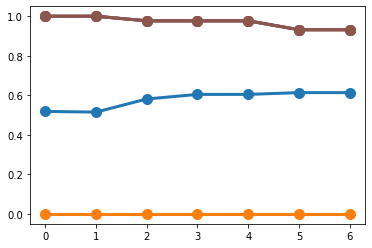

In [58]:
plt.plot(repo1['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(repo1['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(repo1['m3'], linewidth=3, marker='o', markersize=10)
plt.plot(repo1['m4'], linewidth=3, marker='o', markersize=10)
plt.plot(repo1['m5'], linewidth=3, marker='o', markersize=10)
plt.plot(repo1['m6'], linewidth=3, marker='o', markersize=10)

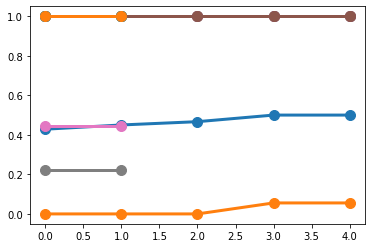

In [59]:

plt.plot(repo2['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(repo2['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(repo2['m3'], linewidth=3, marker='o', markersize=10)
plt.plot(repo2['m4'], linewidth=3, marker='o', markersize=10)
plt.plot(repo2['m5'], linewidth=3, marker='o', markersize=10)
plt.plot(repo2['m6'], linewidth=3, marker='o', markersize=10)

plt.plot(repo3['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(repo3['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(repo3['m3'], linewidth=3, marker='o', markersize=10)
plt.plot(repo3['m4'], linewidth=3, marker='o', markersize=10)
plt.plot(repo3['m5'], linewidth=3, marker='o', markersize=10)
plt.plot(repo3['m6'], linewidth=3, marker='o', markersize=10)

### Quality factor and aspect aggregation

- You must do this for each of your repositories

In [60]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.25
pm5 = 0.25
pm6 = 0.5

repo1['code_quality'] = ((repo1['m1']*pm1) + (repo1['m2']*pm2) + (repo1['m3']*pm3)) * psc1
repo2['code_quality'] = ((repo2['m1']*pm1) + (repo2['m2']*pm2) + (repo2['m3']*pm3)) * psc1
repo3['code_quality'] = ((repo3['m1']*pm1) + (repo3['m2']*pm2) + (repo3['m3']*pm3)) * psc1

repo1['testing_status'] = ((repo1['m4']*pm4) + (repo1['m5']*pm5) + (repo1['m6']*pm6)) * psc2
repo2['testing_status'] = ((repo2['m4']*pm4) + (repo2['m5']*pm5) + (repo2['m6']*pm6)) * psc2
repo3['testing_status'] = ((repo3['m4']*pm4) + (repo3['m5']*pm5) + (repo3['m6']*pm6)) * psc2


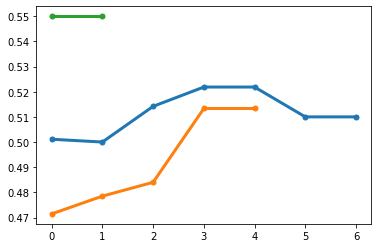

In [61]:
plt.plot(repo1['code_quality'], linewidth=3, marker='o', markersize=5)
plt.plot(repo2['code_quality'], linewidth=3, marker='o', markersize=5)
plt.plot(repo3['code_quality'], linewidth=3, marker='o', markersize=5)

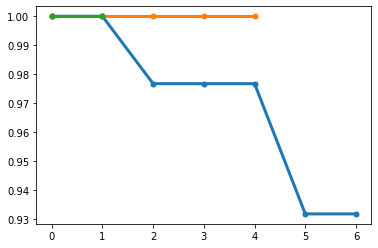

In [62]:

plt.plot(repo1['testing_status'], linewidth=3, marker='o', markersize=5)
plt.plot(repo2['testing_status'], linewidth=3, marker='o', markersize=5)
plt.plot(repo3['testing_status'], linewidth=3, marker='o', markersize=5)


In [63]:
metrics_df = pd.concat([repo1, repo2, repo3], ignore_index=True)

metrics_df['Maintainability'] = metrics_df['code_quality'] * pc1
metrics_df['Reliability'] = metrics_df['testing_status'] * pc2
metrics_df['total'] = metrics_df['Maintainability'] + metrics_df['Reliability']

In [64]:
metrics_df

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0,0.518519,0.000000,1.000000,1.000000,1.000000,1.000000,fga-eps-mds-2022-1-Capju-Interface,0.1.0,1349,0.501111,1.000000,0.250556,0.500000,0.750556
1,0.515152,0.000000,1.000000,1.000000,1.000000,1.000000,fga-eps-mds-2022-1-Capju-Interface,0.2.0,1940,0.500000,1.000000,0.250000,0.500000,0.750000
2,0.581395,0.000000,0.976744,0.976744,0.976744,0.976744,fga-eps-mds-2022-1-Capju-Interface,0.3.0,3083,0.514186,0.976744,0.257093,0.488372,0.745465
3,0.604651,0.000000,0.976744,0.976744,0.976744,0.976744,fga-eps-mds-2022-1-Capju-Interface,0.3.1,3026,0.521860,0.976744,0.260930,0.488372,0.749302
4,0.604651,0.000000,0.976744,0.976744,0.976744,0.976744,fga-eps-mds-2022-1-Capju-Interface,0.3.2,3026,0.521860,0.976744,0.260930,0.488372,0.749302
5,0.613636,0.000000,0.931818,0.931818,0.931818,0.931818,fga-eps-mds-2022-1-Capju-Interface,0.3.3,3259,0.510000,0.931818,0.255000,0.465909,0.720909
6,0.613636,0.000000,0.931818,0.931818,0.931818,0.931818,fga-eps-mds-2022-1-Capju-Interface,0.4.0,3345,0.510000,0.931818,0.255000,0.465909,0.720909
7,0.428571,0.000000,1.000000,1.000000,1.000000,1.000000,fga-eps-mds-2022-1-Capju-Service,0.1.0,801,0.471429,1.000000,0.235714,0.500000,0.735714
8,0.450000,0.000000,1.000000,1.000000,1.000000,1.000000,fga-eps-mds-2022-1-Capju-Service,0.1.0-beta,491,0.478500,1.000000,0.239250,0.500000,0.739250
9,0.466667,0.000000,1.000000,1.000000,1.000000,1.000000,fga-eps-mds-2022-1-Capju-Service,0.2.0,463,0.484000,1.000000,0.242000,0.500000,0.742000


(0.1, 0.7)

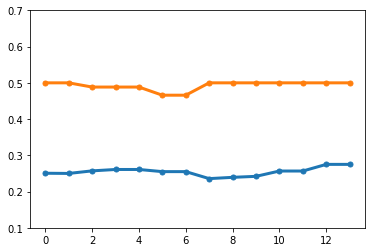

In [65]:
plt.plot(metrics_df['Maintainability'], linewidth=3, marker='o', markersize=5)
plt.plot(metrics_df['Reliability'], linewidth=3, marker='o', markersize=5)

plt.ylim(0.1,.7)

### You must do the total plot and the statics analysis for the repository with more versions.

In [66]:
# Building descriptive statistics dataframe. You must replace YourRepoName for your repository name with more product versions.

more_versions_repo = metrics_df[metrics_df['repository'] == 'fga-eps-mds-2022-1-Capju-Interface']

def get_characteristc_stats(repo_series):
    return {
        'mean': repo_series.mean(),
        'mode': repo_series.mode(),
        'median': repo_series.median(),
        'std': repo_series.std(),
        'var': repo_series.var(),
        'min': repo_series.min(),
        'max': repo_series.max()
    }

maintainability_stats = pd.DataFrame(get_characteristc_stats(more_versions_repo["Maintainability"]),
                                     columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

reliability_stats = pd.DataFrame(get_characteristc_stats(more_versions_repo["Reliability"]),
                                 columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

In [67]:
print(maintainability_stats)

       mean     mode  median       std       var   min      max
0  0.255644  0.25500   0.255  0.004408  0.000019  0.25  0.26093
1  0.255644  0.26093   0.255  0.004408  0.000019  0.25  0.26093


In [68]:
print(reliability_stats)

       mean      mode    median       std       var       min  max
0  0.485276  0.488372  0.488372  0.014216  0.000202  0.465909  0.5


### Plotting the aggregated quality characteristic indicator

{'whiskers': [<matplotlib.lines.Line2D at 0x7fd68d9779a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fd68d977f40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fd68d9776d0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fd68d90a520>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fd68d90a7f0>,
 'means': []}

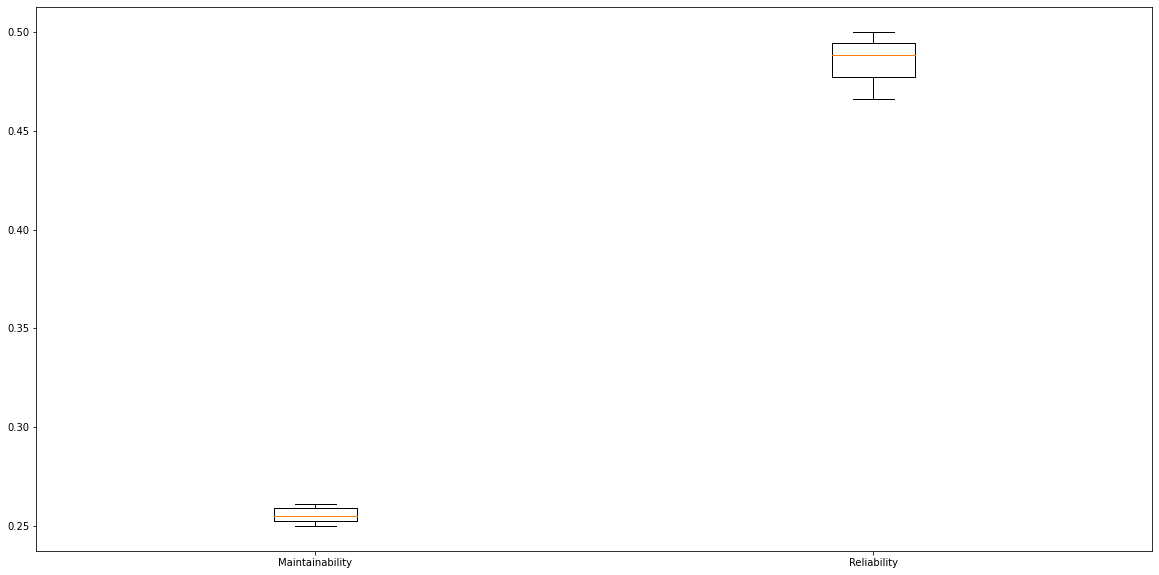

In [69]:
plt.figure(figsize=(20, 10))

# boxplot
plt.boxplot([more_versions_repo['Maintainability'], more_versions_repo['Reliability']],
labels=['Maintainability', 'Reliability'])

### Plotting the aggregated repository quality indicator

(0.1, 1.0)

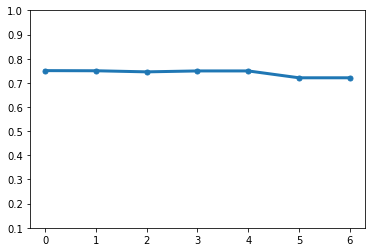

In [70]:
plt.plot(more_versions_repo['total'], linewidth=3, marker='o', markersize=5)

plt.ylim(.1,1)

In [75]:
# DATE FORMAT: MM-DD-YYYY-HH:MM:SS
currentDateTime = datetime.datetime.now().strftime("%m-%d-%Y-%H:%M:%S")

metrics_df.to_excel('data/fga-eps-mds-2022-1-Capju-Interface-{}.xlsx'.format(currentDateTime), index = False)

metrics_df.to_csv('data/fga-eps-mds-2022-1-Capju-Interface-{}.csv'.format(currentDateTime), index = False)